В данной задаче вам предстоит проанализировать 8-канальную запись электроэнцефалограммы, полученную в ходе эксперимента по детекции волны P300. В ходе эксперимента испытуемый смотрел на дисплей с подсветкой на который было нанесено 36 символов в виде матрицы 6x6. Расположение символов соответствовало схеме ниже (нумерация столбцов и строк на дисплее отсутствовала):

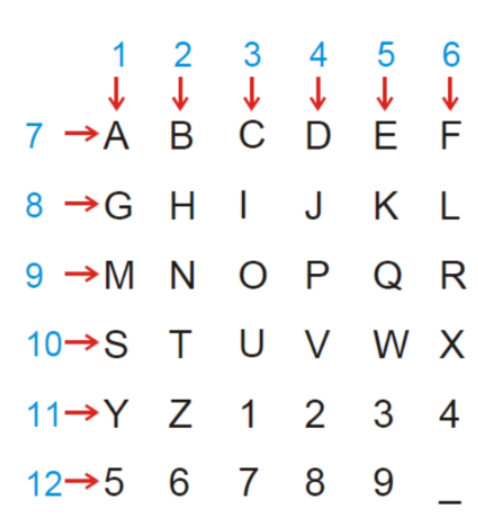

Изначально подсветка дисплея была выключена. Испытуемому подавалась команда ждать момента включения определённого символа на данном дисплее, после чего на нём в случайном порядке по очереди включалась подсветка всех 6 строк таблицы, затем также в случайном порядке всех 6 столбцов (в любой момент времени на дисплее горело не более одной строки или одного столбца). Подсветка строки или столбца включалась на 125 миллисекунд, после чего на 125 миллисекунд вся подсветка выключалась. Таким образом, за одну секунду успевало загореться и погаснуть 4 строки или столбца и, как можно подсчитать, полный проход по всем строкам и столбцам занимал 3 секунды. За это время элемент, подсветки которого ожидал испытуемый загорался два раза (один раз вместе со строкой и один раз вместе со столбцом).

Включение подсветки символа, которое ожидал испытуемый, являлось стимулом вызывающим возникновение волны P300 на ЭЭГ. Однако, в связи с присутствием в сигнале ЭЭГ множества других компонент, P300 довольно сложно с детектировать при одиночном применении стимула, поэтому описанный выше цикл повторялся 10 раз (при каждом новом проходе порядок подсветки строк и столбцов менялся случайным образом).


На рисунке ниже показаны результаты усреднения для используемой в задаче записи ЭЭГ по одному из каналов после появления подсветки ожидаемого символа и в её отсутствие:

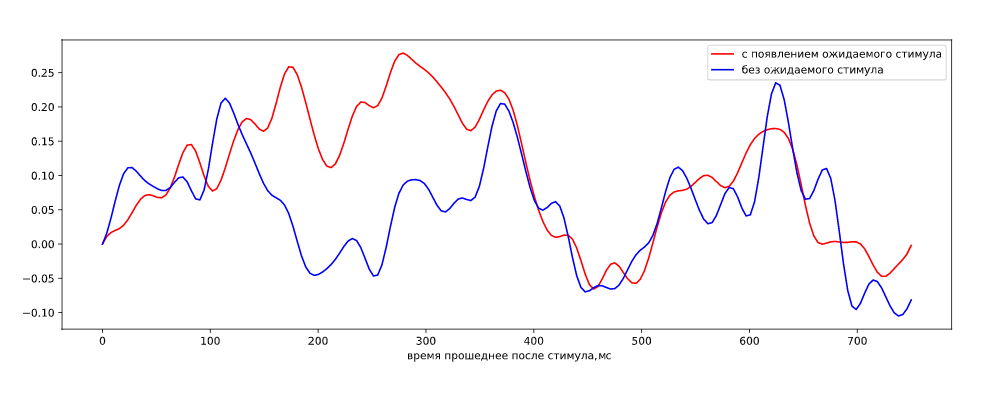


По ссылке вы можете скачать архив содержащий две папки - train и test. В папках находятся .csv файлы. Каждый файл содержит запись электроэнцефалограммы для 10 циклов подсветки символов из таблицы во время которых испытуемый следит за одним определённым символом. Символы из разных файлов могут совпадать. Первые восемь столбцов в каждом файле с индексами ch0, ch1, ch2, ch3, ch4, ch5, ch6, ch7 содержат записи ЭЭГ каналов Oz, Cz, P4, Pz, PO8, Fz, P3, PO7. Частота оцифровки сигнала равна 256 Гц. Девятый столбец label состоит из номеров строк и столбцов согласно схеме выше и 0 для моментов когда ни одни строка и столбец не подсвечены. Файлы из директории train, в отличие от файлов из test содержат десятый столбец target который может принимать одно из трёх возможных значений: 0, если подсветка отключена, 1 - если горит строка или столбец не содержащий символ подсветки которого ожидает участником эксперимента и 2 - если зажглись строка или столбец включающие в себя ожидаемый символ.

Вы должны проанализировать данные из папки train и построить на их основе модель позволяющую определить символы которые ждал пользователь для файлов из папки test. Ответ следует представить в виде строки ожидаемых символов расставленных в порядке нумерации файлов из папки test. Например, если ваша модель определила что файлу test_1.csv соответствует символ A, файлу test_2.csv - символ B, и т.д., то ответом будет являться строка ABCDEFGHIJKLMNO. Оценка за задание выставляется путём умножения максимального балла за это задание на коэффициент k:

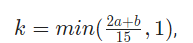

где a - число файлов для которых ожидаемый символ был определён верно, b - число файлов для которых символ был определён неверно, но он находится на той же строке или в том же столбце что и правильный символ.

Эта задача оформлена на Степике как задача на данные, однако файл с данными понадобится исключительно для получения доступа к отправке ответа. Ответ рекомендуется вводить в поле на сайте, чтобы избежать возможных проблем с кодировкой. Чтобы избежать возможных сбоев также рекомендуется нажимать на "Нажмите, чтобы начать решать" уже после того как вы обработаете данные из архива и будете готовы ввести ответ.

In [1]:
# Решение 2 задачи 5 блока 2 этапа трека Нейротехнологии и когнитивные науки
# Олимпиады НТИ 19/20

from collections import defaultdict

import numpy as np
import pandas as pd
from sklearn.svm import SVC

In [5]:
df.head(100)

,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,label,target
0,0.496385,0.456946,-0.027679,-0.239645,-0.269509,1.019539,0.167847,0.101955,0,0
1,0.185337,0.322610,-0.430051,-0.729795,-0.468397,1.027430,-0.166869,-0.057095,0,0
2,-0.355135,0.120093,-0.811549,-1.139736,-0.694403,0.951336,-0.474786,-0.273631,0,0
3,-0.981056,-0.105124,-1.096610,-1.393425,-0.894635,0.799904,-0.700710,-0.534414,0,0
4,-1.486109,-0.293802,-1.205920,-1.437768,-0.989145,0.597059,-0.798567,-0.785661,0,0
...,...,...,...,...,...,...,...,...,...,...
95,0.715382,-0.829529,0.327809,0.438058,0.492624,-0.593130,-0.051007,1.180267,1,1
96,0.769595,-0.891062,0.318364,0.273254,0.309255,-0.665019,-0.166272,1.265145,0,0
97,0.767918,-0.882172,0.259574,0.088842,0.130763,-0.641700,-0.190798,1.273144,0,0
98,0.782267,-0.816084,0.150967,-0.064108,0.023825,-0.528547,-0.097502,1.235140,0,0


In [40]:
def get_avg(path, downsampling = 8):
    """Функция считывает данные из csv-файла, усредняет отрезки записи ЭЭГ по
    значениям колонки labels и подготавливает их для передачи в классификатор"""
    # Считываем данные в DataFrame df.
    df = pd.read_csv(path)
    # Записываем в переменную data массив numpy с сигналом ЭЭГ из файла по всем каналам,
    # в label - столбец label и в target - столбец target, если таковой имеется в DataFrame.
    data = df[[f'ch{i}' for i in range(8)]].values
    label = df['label'].values
    target = df['target'].values if 'target' in df else None
    # В target_labels будем хранить labels соответствующие строкам и столбцам на которых
    # находится элемент подсветки которого ожидает испытуемый.
    target_labels = set()

    # Если обратиться к стандартному dict по отсутствующему ключу возникнет ошибка. Если обратиться
    # к объекту типа defaultdict по отсутствующему в нём ключу, он создаст новый объект указанного
    # при инициализации типа. Т.о. если обратиться к labels_dict по индексу key, который в нём отсутствует,
    # в labels_dict возникнет пара ключ-значение key: [].
    labels_dict = defaultdict(list)
    # Инициализируем labels_dict в цикле. Ключём будет являться элемент label, а значением - список
    # полусекундных отрезков сигнала после зажигания элемента label. В начале инициализируем i значением
    # 64, так как в данных первый элемент таблицы зажигается именно на этом моменте. Увеличиваем i на 64
    # так как строка/столбец посвечивается 125 мс, после чего 125 мс ничего не горит (250 мс соответствует
    # 64 точкам при частоте оцифровки 256 Гц).
    for i in range(64, len(data), 64):
        # Так как get_avg используется для подготовки как обучающих так и тестовых данных, перед обращением
        # к элементу target следует проверить, был ли target инициализирован.
        if target is not None and target[i] == 2.0:
            target_labels.add(label[i])
        # В конце записи имеется полусекундный отрезок, во премя которого таблица символов не подсвечивается.
        # Последнее значение i попадает на его середину. Пропускаем данную итерацию.
        if label[i] == 0.0:
            continue
        # Записываем в chunk 0.5 с записи сигнала ЭЭГ после подсветки определённого столбца/строки.
        # Для корректного усреднения сигнала по всем отрезкам вычитаем из элементов записи начальное значение.
        chunk = data[i:i+128,:]
        chunk -= chunk[0]
        labels_dict[label[i]].append(chunk)
        
    # В ans по ключу label записываем усреднённое значение сигнала после подсветки соответствующих label строк
    # или столбцов таблицы символов. Из этого усреднённого значения сигнала мы берём только часть точек, чтобы
    # снизить размерность пространства признаков. По умолчанию мы берём каждую восьмую точку.  
    ans = {
        key: np.average(val, axis=0)[::downsampling,:] for key, val in labels_dict.items()
    }
    
    # Возвращаем словарь с усреднённым и прореженным сигналом ЭЭГ и множество содержащее номера столбцов/строк
    # таблицы, подсветки которых ожидал испытуемый (для тестовых данных оно пустое).
    return ans, target_labels

In [7]:
def get_train():
    # Функция возвращает массив X с векторами признаков для всех обучающих данных и целевой вектор у. В y мы
    # вводим два класса: 1 для векторов признаков соответствующих участкам сигнала после зажигания ожидаемой
    # строки или столбца и 0 для остальных строк/столбцов.
    X, y = [], []
    for i in range(20):
        path = f'data/train/train_{i}.csv'
        avg_eeg, target_labels = get_avg(path)
        for label, signal in avg_eeg.items():
            X.append(signal.flatten())
            y.append(int(label in target_labels))
    return np.array(X), np.array(y)

In [8]:
def get_test():
    # Функция возвращает массив X с векторами признаков для всех тестовых данных и массив labels с индексами
    # строк и столбцов. i-й элемент X был получен усреднением сигнала после зажигания строки или столбца
    # таблицы символов соответствующей i-му элементу labels.
    X, labels = [], []
    for i in range(15):
        path = f'data/test/test_{i}.csv'
        avg_eeg, _ = get_avg(path)
        for label, signal in avg_eeg.items():
            X.append(signal.flatten())
            labels.append(label)
    return np.array(X), np.array(labels)


In [41]:
X_train,y_train = get_train()
X_test, labels = get_test()

# probability=True позволяет не только предсказывать класс для тестовых данных но и получать вероятности
# принадлежности вектора признаков к каждому из классов.
model = SVC(probability=True, gamma='auto')
model.fit(X_train, y_train)
# В probas записываем вероятности принадлежности векторов признаков к классу 1, т.е. вероятность того, что
# вектор признаков соответствует записи сигнала ЭЭГ после зажигания ожидаемой строки или столбца.
# В X_test каждому файлу с тестовыми данными соответствует 12 элементов - усреднённые и прореженные записи
# ЭЭГ для 6 строк и 6 стоблцов таблицы символов.
probas = model.predict_proba(X_test)[:,1].flatten()

result = ''
letters = [
    'ABCDEF',
    'GHIJKL',
    'MNOPQR',
    'STUVWX',
    'YZ1234',
    '56789_'
]

for i in range(0, 180, 12):
    # Для каждого файла с тестовыми данными ищем индекс колонки и столбца для которых принадлежность к
    # классу 1 максимальна. По полученным индексам находим элемент таблицы символов.
    column_chunk = probas[i:i+6]
    line_chunk = probas[i+6:i+12]
    column = labels[i + column_chunk.argmax()]
    line = labels[i + 6 + line_chunk.argmax()]
    result += letters[line-7][column-1]

# В данной задаче правильным ответом является последовательность YOPOY6JDAIUAGMN. Данное решение даёт
# последовательность символов YNNOZ7PDAJUBKMN. Как видите, строки совпадают не полностью, однако решение
# позволяет с запасом получить максимальный балл за задачу. Его возможно улучшить изменив параметры модели.
print(result)



YNNOZ7PDAJUBKMN
